# Land cover classification at 1-meter spatial resolution using aerial imagery and deep learning

Land cover classification is an important task in remote sensing: land cover maps are integral to monitoring the interaction between humans and the environment, as well as monitoring changes in natural resources. Land cover maps are typically created at medium spatial resolutions using remote sensing data from instruments aboard satellites (such as Landsat and Sentinel-2) that are then processed by pixel-based machine learning algorithms. However, at high resolutions (<5 meters), the effectiveness of pixel-based approaches to classification of remote sensing imagery tends to decrease due to increased intra-class variance and the prevalance of noise in the data. Deep learning approaches, on the other hand, use both spectral and spatial information when processing remote sensing data, alleviating the effects of aforementioned intra-class variance. This purpose of this tutorial is to provide a basic introduction for applying deep learning methods to remote sensing data. In particular, we will be training a modified U-Net semantic segmentation model to create an end-to-end approach to land cover classification.

## Data sources

In order to develop a deep learning model, we need a large source of labelled imagery for supervised training. The Chesapeake land cover dataset is a 6 class 1-meter spatial resolution land cover dataset over the Chesapeake watershed. The labels in the target data correspond to the follwing land cover classes:

    1 = water
    2 = tree canopy / forest
    3 = low vegetation / field
    4 = barren land
    5 = impervious (other)
    6 = impervious (road)
    15 = no data.

For our source imagery, we will use USDA NAIP 4-band (red, green, blue, NIR) aerial imagery resampled to 1-meter ground sampling distance (GSD). The Chesapeake LC dataset was created using NAIP, Landsat 8, NLCD, and building footprint data which is included in the dataset. For simplicity's sake, we will only use the NAIP data. [Follow this link for more information regarding the Chesapeake Bay LULC dataset.](https://www.chesapeakeconservancy.org/conservation-innovation-center/high-resolution-data/lulc-data-project-2022/) Below if the extent of the full LULC dataset.

![cb_extent](./figures/CBLULC_extent.png)

We will only be using a small subset of NAIP data for this example. Data is stored in the `./data` directory in this repository.

## Loading data

In order to load data from rasters into python, we need to use the `rasterio` module. Below is an example of how to open and visualize a file using rasterio.

### Finding files

Before we can load files, we need to know where they are at. In this case, there is some NAIP data that has aleady been sampled stored in `./data` with the following directory structure:

```
| data/
|| NAIP_PATCH_ID/ 
||| input/
|||| 00000.tif (sample from corresponding patch)
|||| 00001.tif
|||| 00002.tif
|||| ...
||| target/
|||| 00000.tif (sampl from corresponding patch's ground truth data)
|||| 00001.tif
|||| 00002.tif
|||| ...
```

Knowing this, we can write a function that aggregates the NAIP data and their corresponding ground truth labels into a list of 2-tuples.

In [1]:
import os
def get_list_of_files(data_path: str='./data') -> list[tuple[str, str]]:
    '''Returns a list of tuples of the form (path_to_input_sample, path_to_label)
    
    Parameters:
    data_path (str): path to the root of the data directory
    
    Returns:
    list[tuple[str, str]]: List of file paths with corresponding ground truth labels
    '''
    
    # get list of patch ids. list comprehension pretty much says "look at the 
    # items in the data_path directory and if they are directories, add them to 
    # the list"
    file_paths = []
    patch_ids = [sub_dir for sub_dir in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, sub_dir))]
    
    for patch in patch_ids:
        # get all subsamples of each patch
        subsamples = os.listdir(os.path.join(data_path, patch, 'input'))
        # add subsamples to file_path list
        file_paths.extend(
            (
                os.path.join(data_path, patch, 'input', subsample),
                os.path.join(data_path, patch, 'target', subsample)
            ) for subsample in subsamples
        )
        
    
    # check to make sure files exist
    for file_path in file_paths:
        if not os.path.isfile(file_path[0]): # if source file doesn't exist
            raise FileNotFoundError(f'Input file {file_path[0]} not found')
        if not os.path.isfile(file_path[1]): # if label file doesn't exist
            raise FileNotFoundError(f'Label file {file_path[1]} not found')
    
    return file_paths
    
    
file_paths = get_list_of_files('./data')
print(f'Found {len(file_paths)} files') # always a good idea to print out the number of files found
print(file_paths[0]) # take a look at the first file path input/target 2-tuple

Found 2464 files
('./data\\m_3607626_ne_18_1\\input\\00000.tif', './data\\m_3607626_ne_18_1\\target\\00000.tif')


Now, lets look through our files and visualize the data to make sure that we have the right data and that we are loading it into Python correctly.

raster metadata: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 224, 'height': 224, 'count': 4, 'crs': CRS.from_epsg(26918), 'transform': Affine(1.0, 0.0, 341463.0,
       0.0, -1.0, 4052712.0)}
raster shape: (4, 224, 224)
red band raster shape: (224, 224)


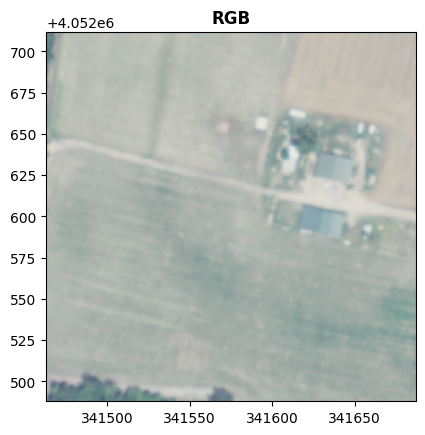

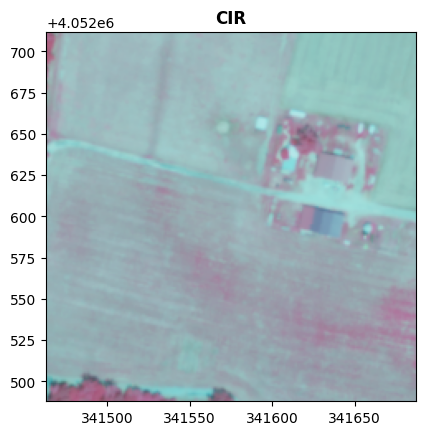

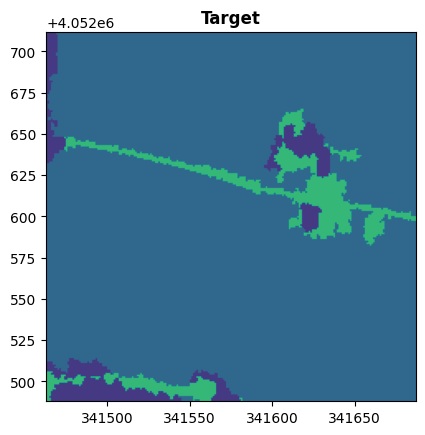

<Axes: title={'center': 'Target'}>

In [2]:
import rasterio
import numpy as np
from rasterio.plot import show

src_file = file_paths[0][0] # first sample, only the input data
with rasterio.open(src_file) as src:
    meta = src.meta # grab geo metadata
    data = src.read() # grab raster data (as numpy array)
    red_band = src.read(1) # only grab red band (as numpy array)
    
print('raster metadata:', meta)
print('raster shape:', data.shape)
print('red band raster shape:', red_band.shape)

data_rgb = data[:3] # create RGB image
show(data_rgb, transform=meta['transform'], vmin=0, vmax=255, title='RGB')
data_cir = data[[3, 0, 1], :, :] # grab only the G R NIR bands
show(data_cir, transform=meta['transform'], vmin=0, vmax=255, title='CIR')

target_file = file_paths[0][1] # first sample, only the target data
with rasterio.open(target_file) as src:
    target_meta = src.meta # grab geo metadata
    target = src.read() # grab raster data (as numpy array)
    
show(target, transform=target_meta['transform'], vmin=1, vmax=7, title='Target')

In order to make our life easier down the line, let's go ahead and create a few helper functions for working with raster data. First, let's create a function that prints the shape (dimensionality) of an array, along with other important properties.

In [3]:
def print_array_info(array):
    print('array shape:', array.shape)
    print('array dtype:', array.dtype)
    print('array range:', array.min(), array.max())
    
print_array_info(data)
print_array_info(target)

array shape: (4, 224, 224)
array dtype: uint8
array range: 59 234
array shape: (1, 224, 224)
array dtype: uint8
array range: 2 5


Now, let's create functions for vizualizing raster and label data easily.

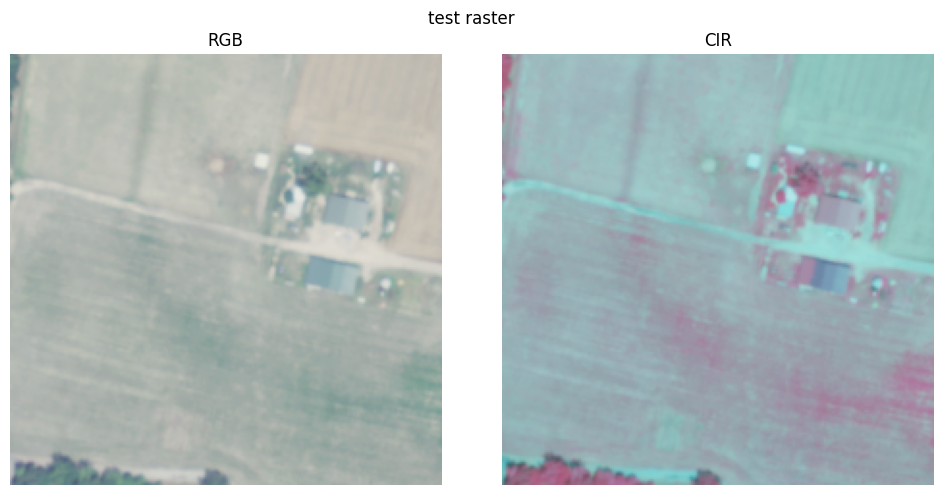

In [4]:
import matplotlib.pyplot as plt

def visualize_raster(raster, title=None):
    
    rgb = raster[:3] # create RGB image
    cir = raster[[3, 0, 1], :, :] # grab only the G R NIR bands
    
    rgb = rgb.transpose(1, 2, 0) # convert from (bands, rows, cols) to (rows, cols, bands)
    cir = cir.transpose(1, 2, 0)
    
    # create plt figure
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # plot RGB image
    ax[0].imshow(rgb, vmin=0, vmax=255)
    ax[0].set_title('RGB')
    ax[0].axis('off')
    
    # plot CIR image
    ax[1].imshow(cir, vmin=0, vmax=255)
    ax[1].set_title('CIR')
    ax[1].axis('off')
    
    if title is not None:
        fig.suptitle(title)
    
    fig.tight_layout() # formatting
    plt.show()
    
visualize_raster(data, 'test raster')

When creating maps from land cover data, often it is convenient to create a color profile that corresponds to the legend elements instead of using a standard color map. As a refresher - here are the land cover classes we are working with:

    1 = water
    2 = tree canopy / forest
    3 = low vegetation / field
    4 = barren land
    5 = impervious (other)
    6 = impervious (road)
    15 = no data.

Thankfully, `matplotlib` provides an easy interface for creating a custom color map using the `ListedColorMap` class, and an interface for customizing legend entries with the corresponding colors using the `Patch` class.

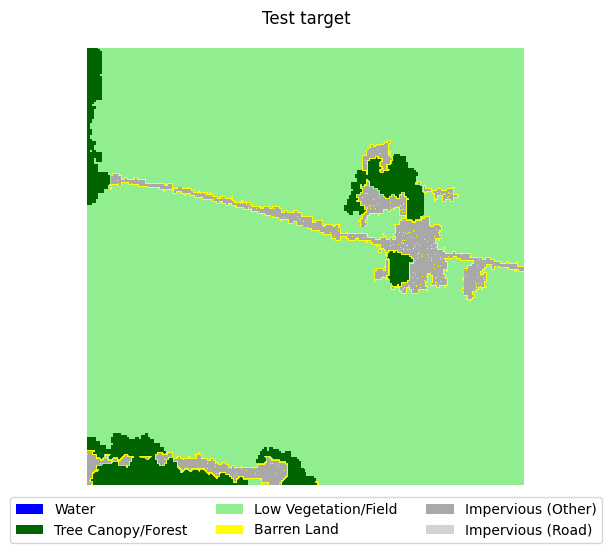

In [5]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

land_cover_colors = [
    'blue', # 1 - water
    'darkgreen', # 2 - tree canopy/forest
    'lightgreen', # 3 - low vegetation/field
    'yellow', # 4 - barren land
    'darkgray', # 5 - impervious (other)
    'lightgray', # 6 - impervious (road)
] # no nodata samples in our dataset, so no need to add a nodata color

land_cover_cmap = ListedColormap(land_cover_colors, name='land-cover') # create color map object
land_cover_legend = [
    Patch(facecolor=land_cover_colors[0], label='Water'),
    Patch(facecolor=land_cover_colors[1], label='Tree Canopy/Forest'),
    Patch(facecolor=land_cover_colors[2], label='Low Vegetation/Field'),
    Patch(facecolor=land_cover_colors[3], label='Barren Land'),
    Patch(facecolor=land_cover_colors[4], label='Impervious (Other)'),
    Patch(facecolor=land_cover_colors[5], label='Impervious (Road)'),
]

def visualize_target(target, title=None):
    
    if target.ndim == 3: target = target.squeeze(0) # remove extra dimension if necessary
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    ax.imshow(target, cmap=land_cover_cmap, vmin=0, vmax=6) # plot target image
    ax.axis('off')
    
    fig.legend(handles=land_cover_legend, loc='lower center', bbox_to_anchor=(0.5, -.1), ncol=3) # add legend
    
    if title is not None:
        fig.suptitle(title)
        
    fig.tight_layout()
    plt.show()

target = target - 1# subtract 1 from all values to make the range 0-6 instead of 1-7
visualize_target(target, 'Test target')

### Creating train/test/val splits

When training a deep learning model, we need at least 2 different dataset splits: a training split which consists of samples the models will train with, and a holdout set with samples that the model will not use during training. Additionally, it is also a good idea to create a validation set that is similar in size to the test split that will be used after each epoch is training is completed to determine how well the model can generalize to unseen data. If the loss calculated on the validation set is significantly greater than that of the training dataset, then our model is *overfitting*. Backpropogagtion is *not* performed on the validation or test splits meaning they have no impact on the parameters or performance of the model - these splits exist purely for evaluation purposes. 

In this example, we are simply going to randomly choose samples to go in each split. Typically 20% of the dataset is placed in the test and validation splits, wheras the remaining 60% is placed in the validation split.

In [6]:
import random
random.seed(1701) # set random seed for reproducibility

n_total_samples = len(file_paths)
n_test_samples = int(n_total_samples * 0.2) # 20% of data will be used for testing
n_val_samples = int(n_total_samples * 0.2) # 20% of data will be used for validation
n_train_samples = n_total_samples - n_test_samples - n_val_samples # the rest of the data will be used for training

print(f'Total samples: {n_total_samples}')
print(f'Train samples: {n_train_samples}')
print(f'Validation samples: {n_val_samples}')
print(f'Test samples: {n_test_samples}')

# shuffle the file paths (in-place operation)
random.shuffle(file_paths)

# split file paths into train, test, and validation sets
train_file_paths = file_paths[:n_train_samples]
val_file_paths = file_paths[n_train_samples:n_train_samples+n_val_samples]
test_file_paths = file_paths[n_train_samples+n_val_samples:]

Total samples: 2464
Train samples: 1480
Validation samples: 492
Test samples: 492


### Creating a Dataset class

In order to load data to train a neural network model in PyTorch, we need to create a custom class that tells PyTorch *how* to load each sample into memory, and what transformations need to be performed on each sample. If you're unfamiliar with this practice, you may not immediately see the value in it compared to simply using a list of samples or `numpy` arrays. Indeed, it may seem like more unnecessary boiler-plate code, but there are several important reasons why creating a custom `torch.utils.data.Dataset` class has its advantages:

1. Subclassing `Dataset` gives us near complete control on how data is loaded and passed to the model. For small, simple datasets it often more than enough to use a `numpy` array to load samples for training. However, when working with large, complicated datasets, we often need to load samples directly from the disk on the fly and transform them to be suitable for training. Using the `__getitem__` method gives us near-unlimited options with regards to the type of data we need to load, how that data is stored (memory, disk, network, etc.), and any transforms/pre-processing that needs to be performed on the data.

2. Using the `Dataset` class allows us to unlock the powerful features of object-oriented programming. We can store important information about the dataset - such as the distribution of classes, means, standard deviations, metadata, and more and access them easily, from both within the `Dataset` class definition and the object itself. As such, your dataset can have all sorts of useful properties outside of just the data. In the following example, we can have the `__getitem__` method of our `Dataset` class return the metadata of the sample - allowing us to easily save rasters with geospatial information on-the-fly during inference - but we'll save that for another day.

In the following example, we will subclass `Dataset` to create a new `NAIP_Dataset` class with functions specific to raster data. Notably, we will load rasters into memory as they are requested instead of loading the entire dataset into memory. Pay extra attention to the `__getitem__` method in the following class definition.

In [7]:
import torch
from torch.utils.data import Dataset

# our custom NAIP_Dataset class will inherit from the Dataset class
class NAIP_Dataset(Dataset):
    
    def __init__(self, files: list[tuple[str, str]], transform=None):
        self.file_path_list = files
        self.transform = transform # more on this later
        self.class_dist = None # we will use this later
        
        # for standardizing input data
        self.min = 0 
        self.max = 255
        
    def __len__(self):
        return len(self.file_path_list)
    
    # __getitem__() is called when indexed in the form dataset[i]
    # typically a __getitem__() method returns a single sample from the dataset
    # in the form of a tuple: (X, y) where X is the data fed into
    # the model and y is the ground truch label associated with the data.
    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor, dict]:
        
        file_path = self.file_path_list[index] # get file path to laod
        
        # load raster data to memory
        X = rasterio.open(file_path[0]).read()
        y = rasterio.open(file_path[1]).read()
        
        # convert to torch tensors
        X = torch.from_numpy(X).type(torch.FloatTensor) # convert to float tensor
        y = torch.from_numpy(y).type(torch.FloatTensor) # convert to float tensor
        
        # standardize input data
        X = (X - self.min) / (self.max - self.min)
        
        # subtract 1 from labels so that classes are indexed from 0 to 6 (instead of 1 to 7)
        y = y - 1
        
        # image transformations (more on this later)
        if self.transform:
            X, y = self.transform(X, y)
        
        return X, y
    
    # NOTE: we can add additional methods to our custom dataset class to make our
    # lives easier. For example, let's create a method that returns the class distribution
    # of the dataset
    
    def get_class_distribution(self, density: bool=True) -> np.array:
        
        if self.class_dist is not None: return self.class_dist # return cached result if available
        
        # load all labels into memory (as numpy array)
        labels = np.array([rasterio.open(file_path[1]).read() for file_path in self.file_path_list])
        
        # subtract 1 from labels so that classes are indexed from 0 to 6 (instead of 1 to 7)
        labels = labels - 1
        
        # get class distribution using numpy histogram function
        self.class_dist = np.histogram(labels, bins=6, density=density, range=(0, 5))[0]
        
        return self.class_dist

Now, to test out our `NAIP_Dataset` class using a subset of the original dataset.

In [8]:
subset_files = file_paths[:5] # select first 5 samples of full dataset for subset

subset_dataset = NAIP_Dataset(subset_files) # create dataset object

# since the __getitem__ method has been overridden, we can access samples in the 
# dataset using the indexing operator [], similar to how we would index a list
X_temp, y_temp = subset_dataset[0] # get first sample in dataset
print_array_info(X_temp) # NOTE: because X and y are torch tensors, the output will vary sligtly from previous examples
print_array_info(y_temp)

# check how many samples are in the dataset
print(f'Number of samples in dataset: {len(subset_dataset)}') # __len__ method has been overriden

# check class distribution
temp_class_dist = subset_dataset.get_class_distribution()
print('Class distribution:', temp_class_dist)

array shape: torch.Size([4, 224, 224])
array dtype: torch.float32
array range: tensor(0.1333) tensor(0.8824)
array shape: torch.Size([1, 224, 224])
array dtype: torch.float32
array range: tensor(1.) tensor(4.)
Number of samples in dataset: 5
Class distribution: [0.         0.73748246 0.42655293 0.         0.02172513 0.01423948]



#### Image Transforms (Rotate and Flip)

When training a deep learning model for image tasks we need to use as many training samples as possible. One widely-used method for artificially boosting the number of training samples seen by a model during training is data augmentation. Under data augmentation, we randomly apply a series of image transformations to each sample of training data before being passed to the model during the training phase. Some examples of popular augmentation techniques include

* Resizing
* Cropping
* Contrast adjustment
* Color adjustment
* Pixel jitter (shift the value of each pixel slightly)
* Rotation
* Flip (vertical and horizontal).

By augmenting data before training, we try to ensure that the model does not overfit on the dataset. When the model is overfit, the model captures features in the training data too well, leading to poor generalization on other data - significantly reducing the 

array shape: torch.Size([4, 224, 224])
array dtype: torch.float32
array range: tensor(0.1333) tensor(0.8824)
array shape: torch.Size([1, 224, 224])
array dtype: torch.float32
array range: tensor(1.) tensor(4.)


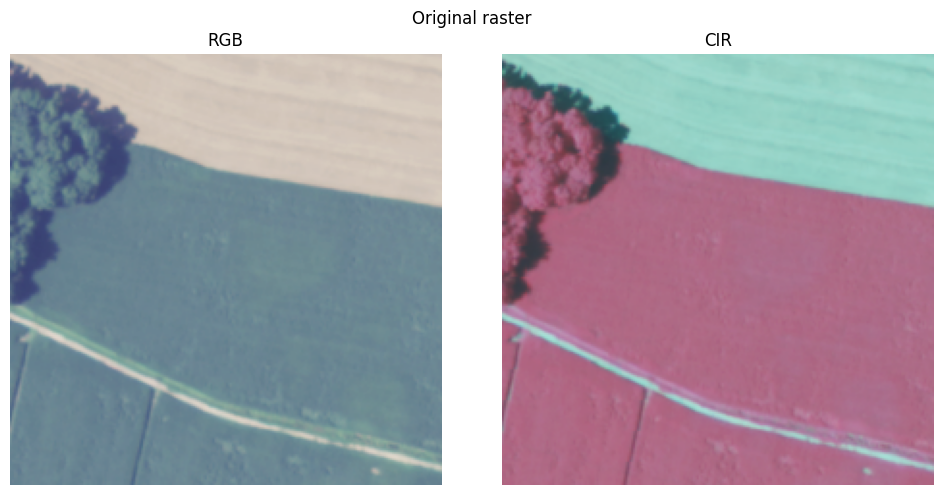

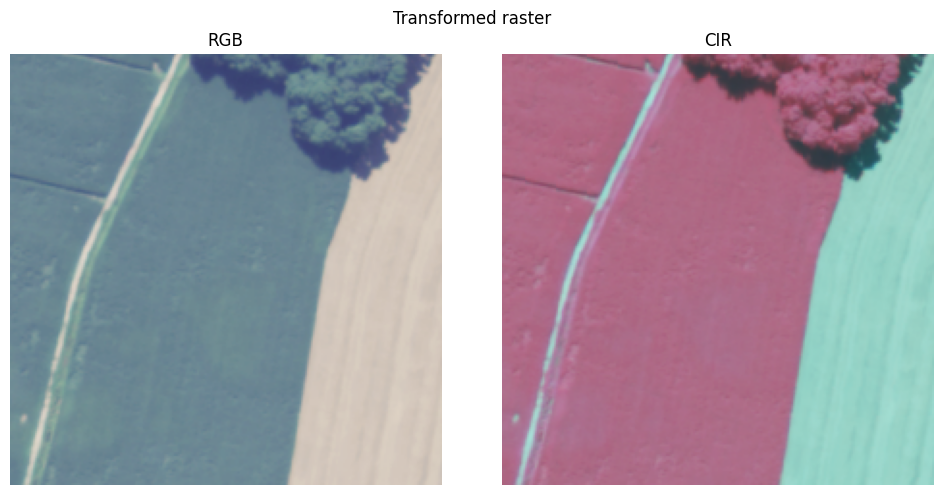

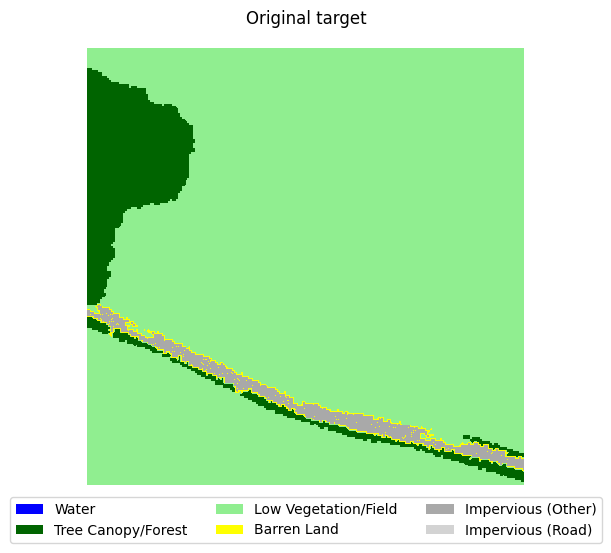

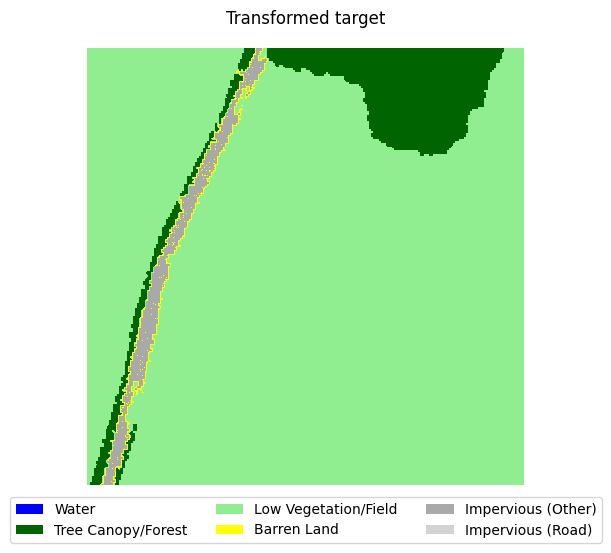

In [9]:
from torchvision.transforms.functional import rotate, hflip, vflip

class RotateAndFlipTransforms:
    
    def __init__(self) -> None:
        self.angles = [90, 180, 270] # possible angles to rotate (0 and 360 are the same as the original)
        self.p_rotate = 0.75 # probability of rotating
        self.p_flip = 0.5 # probability of flipping
    
    def __call__(self, X: torch.Tensor, y: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        
        # rotate with probability p_rotate
        if random.random() < self.p_rotate: 
            angle = random.choice(self.angles) # if rotating, choose a random angle
            X = rotate(X, angle)
            y = rotate(y, angle)

        # horizontal flip with probability p_flip
        if random.random() < self.p_flip: # horizontal flip with probability p_flip
            X = hflip(X)
            y = hflip(y)
            
        # vertical flip with probability p_flip
        if random.random() < self.p_flip:
            X = vflip(X)
            y = vflip(y)
        
        return X, y

transform = RotateAndFlipTransforms()

# testing the transform
X_temp_aug, y_temp_aug = transform(X_temp, y_temp)

# print array info
print_array_info(X_temp_aug)
print_array_info(y_temp_aug)

# visualize transformed data
# NOTE: should convert torch tensors to numpy arrays before visualizing
visualize_raster(X_temp.numpy(), title='Original raster')
visualize_raster(X_temp_aug.numpy(), title='Transformed raster')
visualize_target(y_temp.numpy(), title='Original target')
visualize_target(y_temp_aug.numpy(), title='Transformed target')

### Putting it all together

Now that we have the `NAIP_Dataset` class defined, we can put everything together and create three datasets: a test, val, and train dataset. First, we need to create a `RotateAndFlipTransforms` object, then simply create three new `NAIP_Dataset` objects.

In [10]:
train_dataset = NAIP_Dataset(train_file_paths, transform=RotateAndFlipTransforms()) 
train_class_dist = train_dataset.get_class_distribution()
print('Class distribution for training set:', train_class_dist)

val_dataset = NAIP_Dataset(val_file_paths) # no need for transforms on validation/test sets
val_class_dist = val_dataset.get_class_distribution()
print('Class distribution for validation set:', val_class_dist)

test_dataset = NAIP_Dataset(test_file_paths)
test_class_dist = test_dataset.get_class_distribution()
print('Class distribution for test set:', test_class_dist)

Class distribution for training set: [1.32521190e-01 6.97070065e-01 3.43516024e-01 5.23481669e-04
 1.66144630e-02 9.75477670e-03]
Class distribution for validation set: [0.12950478 0.69571887 0.33793326 0.0011221  0.02350186 0.01221913]
Class distribution for test set: [1.18290933e-01 7.14058271e-01 3.39788238e-01 4.65823715e-04
 1.75134259e-02 9.88330832e-03]


## Model building

Now that we have a means of loading and visualizing data, we can start working on defining the model and it's behavior. Instead 

### Defining U-Net

U-Net is a popular deep learning semantic segmentation architecture that uses convolutional layers to *encode* spatial features in an image to a lower dimensional feature space, then *decodes* the latent space to produce a final segmentation map. Additionally, outputs from the deocoder U-Net was originally developed for binary segmentation of biomedical imagery, but is widely used in many disciplines that frequently deal with 2-Dimensional/3-Dimensional data due to its simplicity and effectiveness. 

In [11]:
# code is modified from https://github.com/milesial/Pytorch-UNet
# in order to comply with GPLv3, link to original code is provided above and 
# GPL v3 license is included in the repository

""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels): # remove bilinear option
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        # CHANGE: remove the bilinear option
        # if bilinear:
        #     self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        #     self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        # else:
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x
        # return self.conv(x)
        
# CHANGE: final "up" layer is different from the rest of the "up" layers due to
# size mismatch between the output of the first "down" layer (64) and the 
# output of the previous "up" layer
class FinalUp(nn.Module):
    """Upscaling then double conv (Upscaling output and DoubleCov input channels mismatch)"""

    def __init__(self, in_channels, middle_channels, out_channels, bilinear=True): # remove bilinear option
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        # CHANGE: remove the bilinear option
        # if bilinear:
        #     self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        #     self.conv = DoubleConv(middle_channels, out_channels, in_channels // 2)
        # else:
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(middle_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x
        # return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

""" Full assembly of the parts to form the complete network """
class UNet(nn.Module):
    # CHANGE: resnet parameter is added to the constructor
    def __init__(self, n_channels, n_classes, resnet): # remove bilinear option
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        # self.bilinear = bilinear # remove bilinear option

        first_output_channels = resnet.conv1.out_channels
        # CHANGE: we are using resnet as our encoder. self.down attributes correspond
        # to the resnet layers. 
        self.inc = (DoubleConv(n_channels, first_output_channels))
        self.down1 = resnet.layer1
        self.down2 = resnet.layer2
        self.down3 = resnet.layer3
        # factor = 2 if bilinear else 1 # remove factor from the constructor
        self.down4 = resnet.layer4
        
        # CHANGE: add self.encoder to easily access the encoder layers via iteration
        self.encoder = [
            self.inc,
            self.down1,
            self.down2,
            self.down3,
            self.down4
        ]
        
        # CHANGE: automatically adjust the number of channels in each layer of the decoder
        # original:
        # self.up1 = (Up(1024, 512 // factor, bilinear))
        # self.up2 = (Up(512, 256 // factor, bilinear))
        # self.up3 = (Up(256, 128 // factor, bilinear))
        # self.up4 = (Up(128, 64, bilinear))
        # self.outc = (OutConv(64, n_classes))
        
        channels = self.get_encoder_output_channels() # get the number of channels in each layer of the encoder
        self.encoder_output_channels = channels
        channels.reverse() # reverse the list of channels to start from the bottom of the decoder
        
        self.up1 = (Up(channels[0], channels[1]))
        self.up2 = (Up(channels[1], channels[2]))
        self.up3 = (Up(channels[2], channels[3]))
        self.up4 = (FinalUp(channels[3], (channels[3] // 2) + first_output_channels, channels[4]))
        self.outc = (OutConv(channels[4], n_classes))

    # CHANGE: helper function to get the number of channels in each layer of the encoder
    def get_encoder_output_channels(self):
        x = torch.randn(1, self.n_channels, 256, 256)
        
        encoder_channels = []
        for layer in self.encoder:
            x = layer(x)
            encoder_channels.append(x.shape[1])
        
        return encoder_channels
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        logits = self.outc(x)
        return logits


### Using a ResNet backbone with pretrained weights

We can leverage the power of pretrained weights by using pretrained weights in our ResNet backbone. During pretraining, a model is trained on a very large labelled dataset to "warm-up" the weights in the layers. When those weights are used in the downstream task (land cover classification/semantic segmentation in this case), the model already has learned how to capture spatial features and is simply fine-tuned on the dataset. This practice is referred to as *transfer learning* since weights are transferred from the pre-training task to a downstream task. Since the model can already embed spatial features, it will generally converge much quicker on the downstream task without the need for large amounts of data.

In [12]:
from timm.models.resnet import resnet18
backbone = resnet18(pretrained=True, in_chans=4) # use pretrained weights from imagenet
model = UNet(n_channels=4, n_classes=6, resnet=backbone) # create model and move to cpu (for now)

d:\projects\UNet_NAIP\NAIP_UNet_Example\.env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Testing our model

Now that the model has been created, it is a good idea to test it by creating a random input and passing it through the model. We do this to make sure the inputs and outputs match the dimensions of our dataset. In this case, our input is four-band imagery at 224x224 resolution, and our output should match the input resolution with 6 channels (one channel for each class).

Note that from now on, we will be primarily working with *torch tensors* instead of numpy arrays. A tensor is very similar to numpy array, but has spetial methods and attributes specifically designed for deep learning applications. For example, tensors can be placed in main memory (CPU), or on the GPU for increased performance during training and inference. Also note that Pytorch models expect inputs to have 4 dimensions. The first dimension refers to the batch size (i.e., we stack 16 tensors of shape (4, 224, 224) on top of each other to get a tensor with shape (16, 4, 224, 224)). The second dimension refers to the number of channels in the input data. Typically when working with RGB imagery, only 3 input channels are needed. In our case, we are using 4-band data, so our model needs four input channels. The final two dimensions refer to the height and width of the input data, respectively.

In [13]:
test_x = torch.randn(1, 4, 256, 256) # create a random input sample (dummy)
test_y = model(test_x) # feed the input sample to the model
print('Output shape:', test_y.shape) # print the output shape
assert test_y.shape == (1, 6, 256, 256) # make sure the output shape is correct

Output shape: torch.Size([1, 6, 256, 256])


### Freezing the backbone

Since we're using pretrained weights in the encoder (sans the input layer), we can freeze those layers to reduce the total number of parameters needed to train. We do this since the encoder is already trained to embed spatial features (edges, corners, shapes, etc.), all we need to train is the decoder to reconstruct a land cover map from said spatial embeddings.

In [14]:
# first layer of encoder is not from resnet, so it should be trainable
# for layer_idx in range(1, len(model.encoder)):
#     # iterate through params in layer and set requires_grad to False
#     for param in model.encoder[layer_idx].parameters():
#         param.requires_grad_(False)

## Training the model

### Defining a loss function (focal loss)

Before the model can be trained, we need to define a criterion to minimize. Typically, a cross-entropy loss function is used for semantic segmentation. However, because our dataset has a very extreme class imbalance, focal loss is a good approach to alleviate problems that arise when training on unbalanced datasets. [From the paper:](https://arxiv.org/abs/1708.02002)

> "Our novel Focal Loss focuses training on a sparse set of hard examples and prevents the vast number of easy negatives from overwhelming the detector during training."

More specifically, focal loss adds a modulating factor to the cross entropy loss, such that

$ \ell(p_t) = -(1-p_t)^{\gamma} \log{p_t} $,

where $ p_t = p $, the model's estimated probability for the class label when the classification is correct, and $ p_t = 1 - p $ when the classification is incorrect. The presence of the modulating factor $ (1-p_t)^{\gamma} $ forces the model to focus on samples that are harder to classify. This is particularly handy in vision problems, where unbalanced datasets are common. Note that we can also include the class weight term $ \alpha $ into the such that $ \ell(p_t) = - \alpha (1-p_t)^{\gamma} \log{p_t} $ to further assist in training on unbalanced datasets.

Loss:  0.5698702931404114


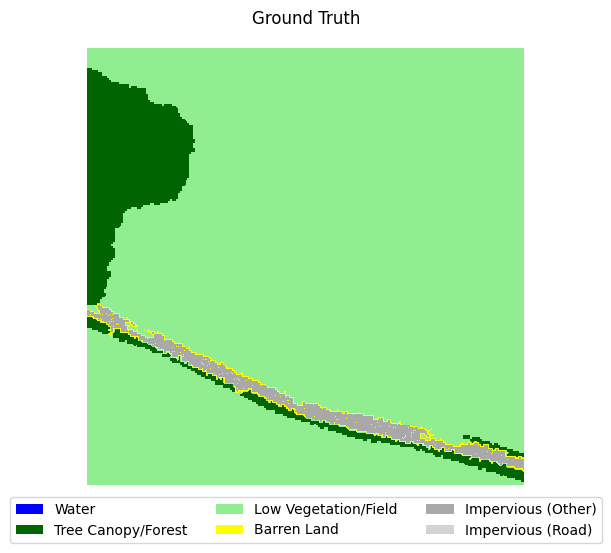

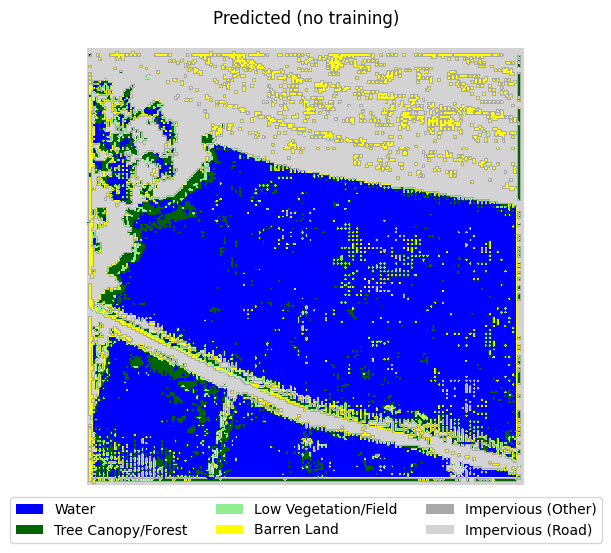

In [15]:
# basic focal loss implementation from 
# https://github.com/AdeelH/pytorch-multi-class-focal-loss/blob/master/focal_loss.py
from torch.nn import functional as F

class FocalLoss(nn.Module):
    """ Focal Loss, as described in https://arxiv.org/abs/1708.02002.

    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.

    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(self, alpha=None, gamma=2., ignore_index=-100):
        """Constructor.

        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 2.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """

        super().__init__()
        if alpha is not None:
            if not isinstance(alpha, torch.Tensor):
                alpha = torch.tensor(alpha)
            alpha = alpha.float()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index

        self.nll_loss = nn.NLLLoss(weight=alpha, reduction='none', ignore_index=ignore_index)

    def forward(self, x, y):
        
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0: return torch.tensor(0.)
        x = x[unignored_mask]

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        # print(x.dtype)
        log_p = F.log_softmax(x, dim=-1)
        y = y.long() # https://discuss.pytorch.org/t/runtimeerror-expected-object-of-scalar-type-long-but-got-scalar-type-float-when-using-crossentropyloss/30542/2
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt)**self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce
        loss = loss.mean() # only using mean reduction for simplicity

        return loss

# quick test of focal loss
X_loss_test, y_loss_test = subset_dataset[0] # get first sample in dataset

# need to add batch dimension to input and target
X_loss_test = X_loss_test.unsqueeze(0)
y_loss_test = y_loss_test.unsqueeze(0)

test_class_weights = subset_dataset.get_class_distribution(density=True) # get class distribution of dataset for loss weights
test_loss_fn = FocalLoss(alpha=test_class_weights) # create loss function object

y_hat_loss_test = model(X_loss_test) # run inference
test_loss = test_loss_fn(y_hat_loss_test, y_loss_test) # calculate loss

print('Loss: ', test_loss.item())

# Visualize inferred image. Will look bad at first, that's okay
y_raster = y_hat_loss_test.squeeze().detach() # convert target to numpy array
y_raster = y_raster.numpy()
y_raster = y_raster.argmax(axis=0)

visualize_target(y_loss_test.squeeze().numpy(), title='Ground Truth')
visualize_target(y_raster, title='Predicted (no training)')

### Hyperparameters, optimization, and GPU acceleration

Now, we can set the hyperparameters, configure our optimizer, and set up GPU acceleration. For simplicity's sake, we'll use the Adam optimizer and a batch sixe of 16.

In [16]:
LEARNING_RATE = 0.001 # learning rate for optimizer
BATCH_SIZE = 16 # batch size to use
NUM_EPOCHS = 100 # number of epochs to train for
FL_GAMMA = 2.0 # gamma parameter for focal loss
PATIENCE = 10 # patience for early stopping

In [17]:
# optimizer and loss function setup
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = FocalLoss(gamma=FL_GAMMA)

# use GPU if avaliable
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [18]:
model.to(device) # move model to GPU if available
loss_fn.to(device) # move loss function to GPU if available

# visualize model architecture + number of trainable parameters
from torchinfo import summary
summary(model, input_size=(BATCH_SIZE, 4, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [16, 6, 256, 256]         --
├─DoubleConv: 1-1                        [16, 64, 256, 256]        --
│    └─Sequential: 2-1                   [16, 64, 256, 256]        --
│    │    └─Conv2d: 3-1                  [16, 64, 256, 256]        2,304
│    │    └─BatchNorm2d: 3-2             [16, 64, 256, 256]        128
│    │    └─ReLU: 3-3                    [16, 64, 256, 256]        --
│    │    └─Conv2d: 3-4                  [16, 64, 256, 256]        36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 256, 256]        128
│    │    └─ReLU: 3-6                    [16, 64, 256, 256]        --
├─Sequential: 1-2                        [16, 64, 256, 256]        --
│    └─BasicBlock: 2-2                   [16, 64, 256, 256]        --
│    │    └─Conv2d: 3-7                  [16, 64, 256, 256]        36,864
│    │    └─BatchNorm2d: 3-8             [16, 64, 256, 256]        128
│

### DataLoader

PyTorch uses the DataLoader class to select and batch samples during training. Because we are using a validation set as well as a training set, 

In [19]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=False)

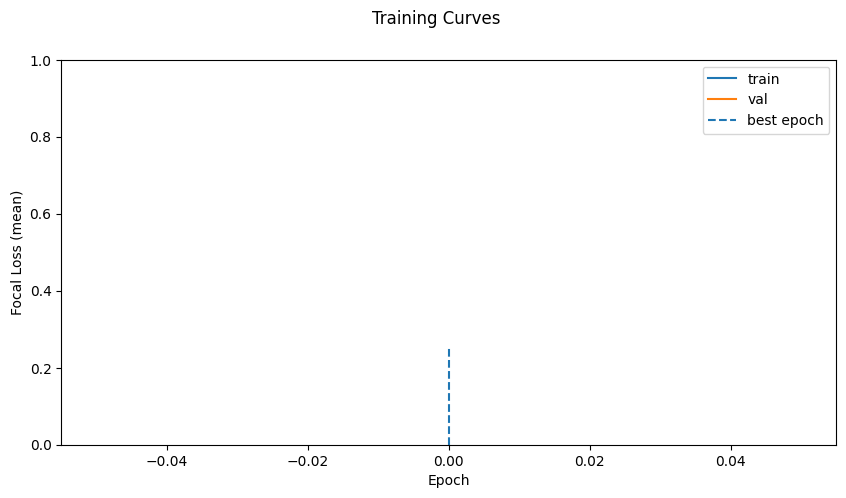

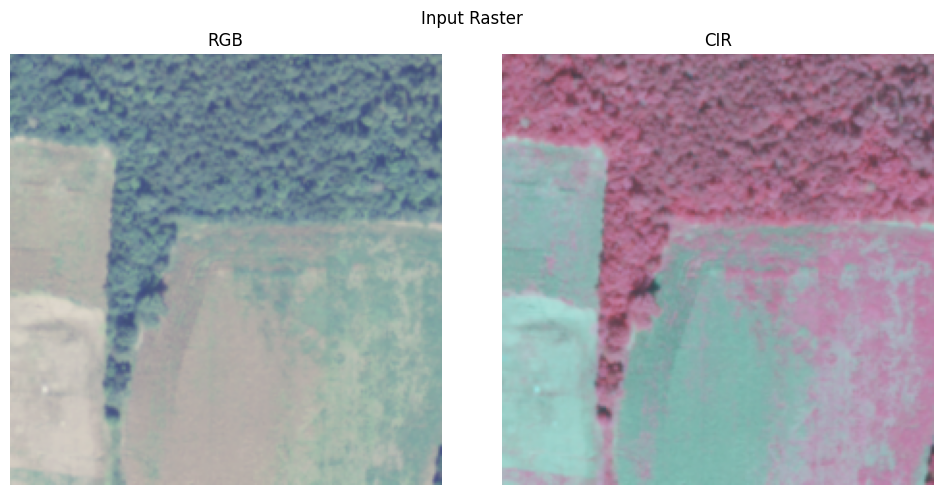

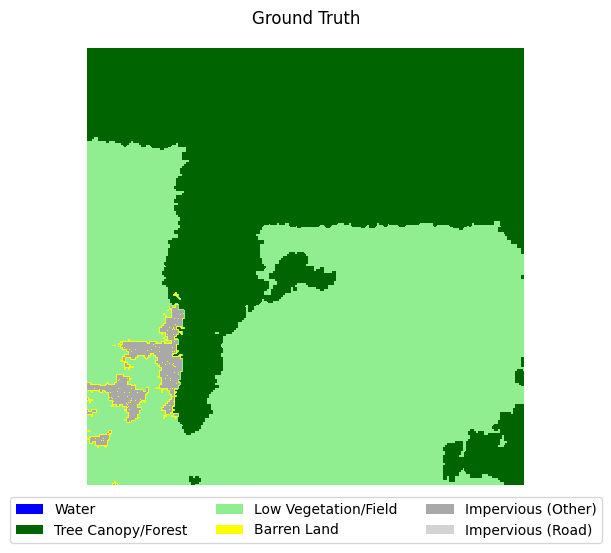

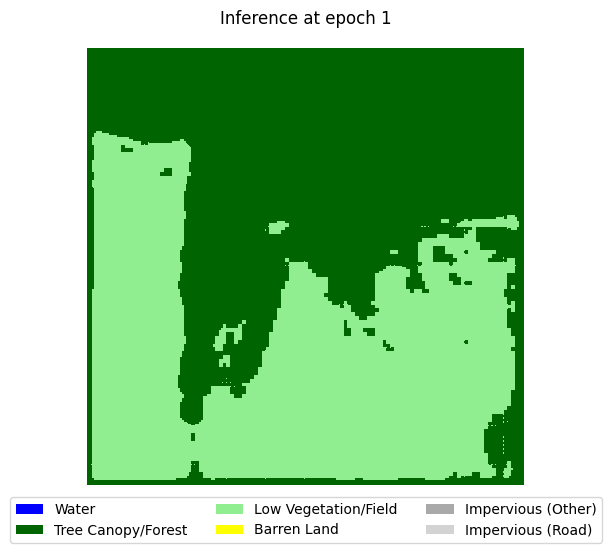

Epoch 2/100 train step:  47%|████▋     | 44/93 [00:16<00:18,  2.72batch/s, loss=0.168]

In [28]:
from tqdm import tqdm # for progress bars
from IPython.display import clear_output # for clearing output in jupyter notebook

# save loss values for plotting
train_losses = []
val_losses = []

# only want to save the model with the best validation loss
best_epoch = 0
best_val_loss = float('inf') # set best validation loss to infinity to start

for epoch in range(NUM_EPOCHS):

    # train step
    epoch_train_loss = 0.0
    model.train() # set model to train mode (enables autograd and dropout)

    with tqdm(train_loader, unit="batch", desc=f'Epoch {epoch+1}/{NUM_EPOCHS} train step') as t_train: # create a progress bar for training
        for X, y in t_train:
            # move data to GPU if available
            X = X.to(device)
            y = y.to(device)
            
            y_hat = model(X)
            loss = loss_fn(y_hat, y)
            epoch_train_loss += (loss.item() * len(X)) # add total batch loss to epoch loss
            t_train.set_postfix(loss=loss.item())
            
            loss.backward() # backpropagate loss
            optimizer.step() # update optimizer parameters (lr, momentum, etc.)
    
    train_losses.append(epoch_train_loss / len(train_dataset)) # calculate average loss for epoch and append to list
    
    # validation step
    epoch_val_loss = 0.0
    model.eval() # set model to eval mode (disables autograd and dropout)
    with tqdm(val_loader, unit="batch", desc=f'Epoch {epoch+1}/{NUM_EPOCHS} val step') as t_val: # create a progress bar for validation
        for X, y in t_val:
            # move data to GPU if available
            X = X.to(device)
            y = y.to(device)
            
            y_hat = model(X)
            loss = loss_fn(y_hat, y)
            epoch_val_loss += (loss.item() * len(X)) # add total batch loss to epoch loss
            t_val.set_postfix(loss=loss.item())
    
    val_losses.append(epoch_val_loss / len(val_dataset)) # calculate average loss for epoch and append to list
    
    # update best validation loss and save model if new best is found
    if loss < best_val_loss:
        best_val_loss = loss
        best_epoch = epoch
        torch.save(model.state_dict(), './best_model.pth')
        
    # plot training curves
    clear_output(wait=True)
    fig = plt.figure(figsize=(10, 5))
    fig.suptitle('Training Curves')
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Focal Loss (mean)')
    plt.vlines(best_epoch, ymin=0, ymax=1, label='best epoch', linestyles='dashed')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()
    
    # show example prediction
    y_hat_plot = y_hat[0].detach().cpu().numpy() # convert target to numpy array\
    y_hat_plot = y_hat_plot.argmax(axis=0)
    visualize_raster(X[0].cpu().numpy(), title='Input Raster')
    visualize_target(y[0].cpu().numpy(), title='Ground Truth')
    visualize_target(y_hat_plot, title=f'Inference at epoch {epoch+1}')
    
    # early stopping
    if epoch - best_epoch > PATIENCE:
        print(f'Validation loss has not improved for {PATIENCE} epochs. Stopping early at epoch {epoch+1}')
        break

## Evaluation

Now that the model has been trained, the final (and most important) step is to determine the model's performance by performing inference on an annotated holdout "test" set. 

### Metrics

The simplest way to construct metrics on a per-class basis is to first count the number of true positives, false positives, true negatives, and false negatives by comparing the ground truth data and the models predictions. For enhanced accuracy, we can do this on a per-class basis. 

> True Positives ($ TP $): positive prediction is correct - ($ \hat{y} = 1; y = 1 $)
>
> False Positives/type I error ($ FP $): positive prediction is incorrect - ($ \hat{y} = 1; y = 0 $)
> 
> True Negatives ($ TN $): negative prediction is correct - ($ \hat{y} = 0; y = 0 $)
>
> False Negative/type II error ($ FN $): negative prediction is incorrect - ($ \hat{y} = 0; y = 1 $)

Next, using these values, we can construct accuracy metrics:

> Accuracy: ratio of correct predictions to the total number of predictions ($ ACC = \frac{TP + TN}{TP + FP + TN + FN} $)
>
> User's accuracy/precision: ratio of total number of true positives to true positives and false positives ($ UA = \frac{TP}{TP + FP} $)
>
> Producer's accuracy/recall: ratio of total number of true positives to true positives and false negatives ($ PA = \frac{TP}{TP + FN} $)
>
> Intersection over Union (IoU): ratio of true positives to true positives, false positives, and false negatives ($IoU = \frac{TP}{TP + FP + FN} $)
>
> F1-score: harmonic mean of user's accuracy and producer's accuracy - commonly referred to as precision and recall, respectively ($F1 = \frac{2 \cdot UA \cdot PA}{UA + PA}$)

Typically, a good model will have similar results for both producer's and user's accuracy - large differences between PA and UA typically indicates the model is biased towards certain classes. IoU is a good metric for determining how well the model can discriminate between foreground regions and background regions.

In [22]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=False)
ys = np.array([])
y_hats = np.array([])

for X, y in tqdm(test_loader, unit="batch", desc='Test step'):
    # move data to GPU if available
    X = X.to(device)
    y = y.to(device)

    y_hat = model(X)
    y_hat = y_hat.argmax(axis=1) # convert from one-hot to class index
    ys = np.append(ys, y.detach().cpu().numpy().flatten())
    y_hats = np.append(y_hats, y_hat.detach().cpu().numpy().flatten())


Test step: 100%|██████████| 31/31 [00:24<00:00,  1.28batch/s]


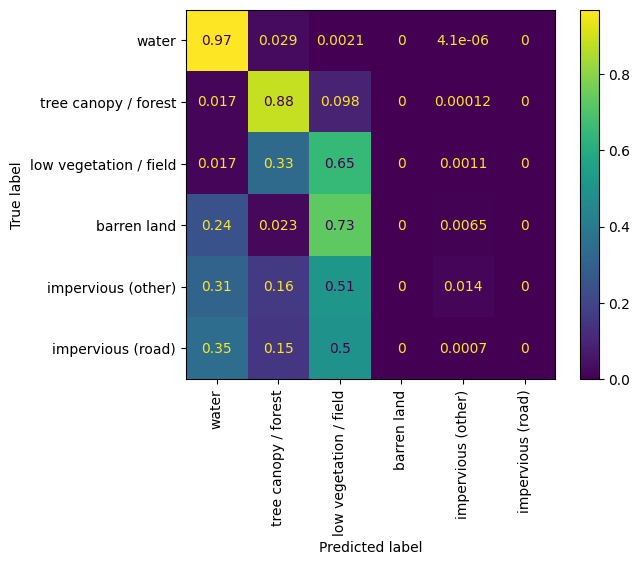

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

lc_labels = [
    'water',
    'tree canopy / forest',
    'low vegetation / field',
    'barren land',
    'impervious (other)',
    'impervious (road)'
]

cm = confusion_matrix(ys, y_hats, normalize='true', labels=range(0,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lc_labels)
disp.plot(xticks_rotation='vertical')